### Processing Derek alert outcomes 
- Created by Grace Patlewicz
- Last modified 22 February 2024
- Changes: Re-processed the Derek outcomes to remove duplicates and re-create the pairwise distance matrix used in the ML

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import os

In [5]:
TOP = os.getcwd().replace('notebooks', '')

In [133]:
raw_dir = TOP + 'data/raw'
processed_dir = TOP + 'data/processed/'
figures_dir = TOP + 'reports/figures/'

In [61]:
df = pd.read_csv(processed_dir+'Derek_outcomes_processed_reach_pairs_300623.csv', index_col = [0])

In [62]:
df.shape

(225, 795)

In [63]:
df['endpoint_revised'] = [e.split('Structure')[0]  for e in df['endpoint']]

In [66]:
df.drop(['endpoint'], axis = 1, inplace = True)

In [92]:
df = df.drop_duplicates()

In [136]:
df.groupby(['endpoint_revised', 'toxicophore']).count()

confidence  \
endpoint_revised                        toxicophore                                                      
Adrenal gland toxicity mammal           Phenylethyltriazole or analogue                              1   
Androgen receptor modulation mammal     4-(2,5-Dioxopyrrolidin-1-yl)benzonitrile or ana...           1   
                                        [1,1'-Biphenyl]-4-carbonitrile or derivative                 2   
Bladder disorders mammal                Trazodone-like                                               1   
Bladder urothelial hyperplasia mammal   Aryl sulphonamide                                            1   
...                                                                                                ...   
Thyroid toxicity mammal                 Permanganate salt                                            1   
                                        Resorcinol or 3-aminophenol                                  2   
Urolithiasis mammal                     Aromatic sulphonamide or methazolamide analogue              1   
                                        Ticrynafen-like                                              1   
alpha-2-mu-Globulin nephropathy mammal  Polyhalogenated benzene                                      1   

                                                                                            DTXSID8027292  \
endpoint_revised                        toxicophore                                                         
Adrenal gland toxicity mammal           Phenylethyltriazole or analogue                                 1   
Androgen receptor modulation mammal     4-(2,5-Dioxopyrrolidin-1-yl)benzonitrile or ana...              1   
                                        [1,1'-Biphenyl]-4-carbonitrile or derivative                    2   
Bladder disorders mammal                Trazodone-like                                                  1   
Bladder urothelial hyperplasia mammal   Aryl sulphonamide                                               1   
...                                                                                                   ...   
Thyroid toxicity mammal                 Permanganate salt                                               1   
                                        Resorcinol or 3-aminophenol                                     2   
Urolithiasis mammal                     Aromatic sulphonamide or methazolamide analogue                 1   
                                        Ticrynafen-like                                                 1   
alpha-2-mu-Globulin nephropathy mammal  Polyhalogenated benzene                                         1   

                                                                                            DTXSID3026932  \
endpoint_revised                        toxicophore                                                         
Adrenal gland toxicity mammal           Phenylethyltriazole or analogue                                 1   
Androgen receptor modulation mammal     4-(2,5-Dioxopyrrolidin-1-yl)benzonitrile or ana...              1   
                                        [1,1'-Biphenyl]-4-carbonitrile or derivative                    2   
Bladder disorders mammal                Trazodone-like                                                  1   
Bladder urothelial hyperplasia mammal   Aryl sulphonamide                                               1   
...                                                                                                   ...   
Thyroid toxicity mammal                 Permanganate salt                                               1   
                                        Resorcinol or 3-aminophenol                                     2   
Urolithiasis mammal                     Aromatic sulphonamide or methazolamide analogue                 1   
                                        Ticrynafen-like                                         

In [104]:
reach_pairs_qsmi = pd.read_csv(processed_dir+'reach_pairs_qsmi.csv', index_col = [0])

In [105]:
#reach_pairs_qsmi

In [106]:
derek1 = df.set_index(['endpoint_revised', 	'toxicophore', 	'confidence'])

In [107]:
alerts = []
for i, row in reach_pairs_qsmi.iterrows():
    a, b = row['source_dtxsid'], row['target_dtxsid']
    c, d = derek1.loc[derek1[a] == 1][a], derek1.loc[derek1[b] ==1][b]
    if len(c) == 0 & len(d) == 0:
        alerts.append([a,b,0,0])
    elif (len(c) == 0) & (len(d) != 0):
        alerts.append([a,b,0,d.sum()])
    elif (len(c) != 0) & (len(d) == 0):
        alerts.append([a,b,c.sum(), 0])
    else:
        alerts.append([a,b,c.sum(),d.sum()])

In [108]:
derek_df = pd.DataFrame(alerts, columns = ['source', 'target', 'source_alert', 'target_alert'])

In [109]:
derek_df1 = derek_df.set_index(['source', 'target'])

In [110]:
derek2 = derek_df1[~((derek_df1['source_alert'] ==0) & (derek_df1['target_alert'] ==0))]

In [111]:
alerts = []
for i, row in derek2.iterrows():
    if row['source_alert'] > row['target_alert']:
        alerts.append(1)
    elif row['source_alert'] == row['target_alert']:
        alerts.append(0)
    else:
        alerts.append(-1)
        

In [112]:
derek2['alerts'] = alerts

/tmp/ipykernel_71314/2220440399.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  derek2['alerts'] = alerts


In [113]:
derek2['alerts'].value_counts()

 1    24
 0    20
-1     6
Name: alerts, dtype: int64

In [128]:
derek2['alert_diff'] = derek2['source_alert'] -derek2['target_alert']

/tmp/ipykernel_71314/2427095752.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  derek2['alert_diff'] = derek2['source_alert'] -derek2['target_alert']


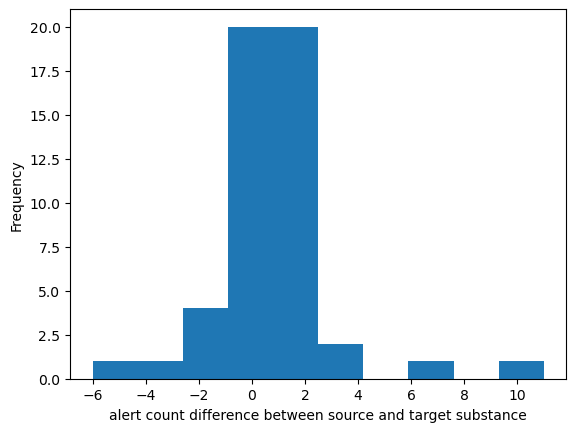

In [134]:
derek2['alert_diff'].plot(kind = 'hist')
plt.xticks(np.arange(-6, 12, 2))
plt.xlabel('alert count difference between source and target substance')
plt.savefig(figures_dir+'derek_alert_count_200224.png', dpi = 300);

In [114]:
import seaborn as sns

In [115]:
ft_copy = df.drop(['confidence'], axis = 1)
ft_copy = ft_copy.groupby(['endpoint_revised', 'toxicophore']).agg(lambda x: x.sum())
ft_copy2 = ft_copy.T
# scipy


In [118]:
ft_copy2 = ft_copy2.applymap(lambda x: 1 if x>=1 else 0)

<Axes: >

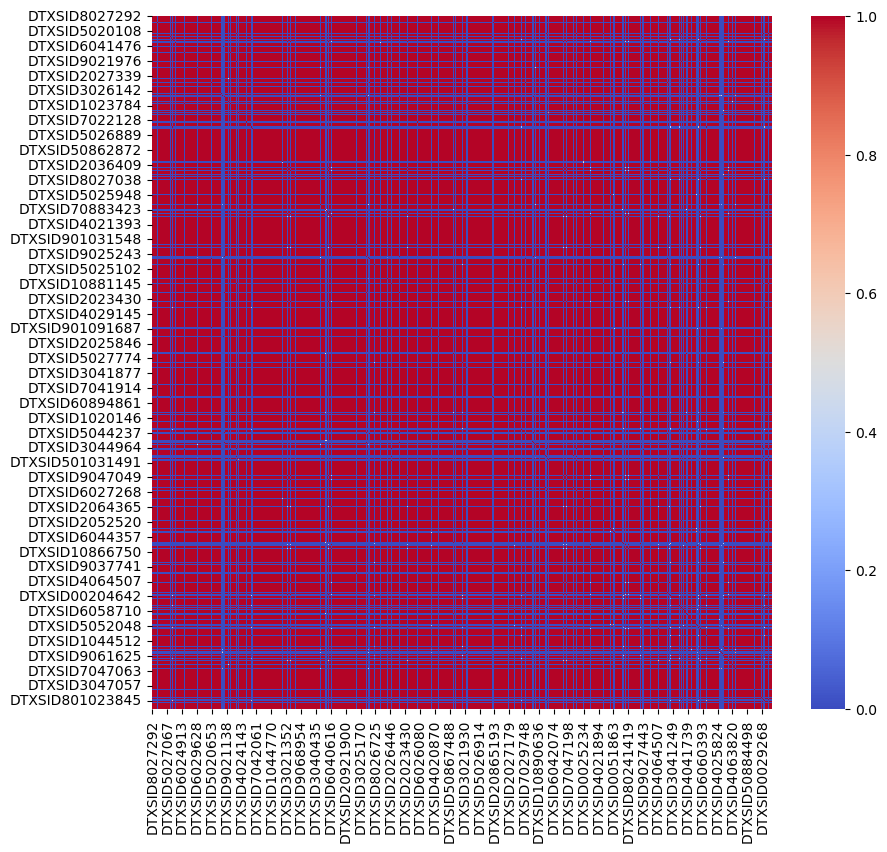

In [119]:
from scipy.spatial.distance import pdist, squareform
D_react = pd.DataFrame(squareform(pdist(ft_copy2, 'jaccard')), columns = ft_copy2.index, index = ft_copy2.index)
S_react = 1- D_react

plt.figure(figsize = (10,9))
sns.heatmap(S_react, cmap = 'coolwarm')

In [120]:
S_react.to_csv(processed_dir+'Sreact_reachpairs_200224.csv')

In [121]:
S_react

,DTXSID8027292,DTXSID3026932,DTXSID4025402,DTXSID6025804,DTXSID9025796,DTXSID2020630,DTXSID0044496,DTXSID00861835,DTXSID2020844,DTXSID5027512,...,DTXSID801023845,DTXSID5041439,DTXSID4020539,DTXSID60894063,DTXSID6040111,DTXSID4049664,DTXSID4042206,DTXSID501104446,DTXSID5038830,DTXSID9074355
DTXSID8027292,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
DTXSID3026932,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
DTXSID4025402,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
DTXSID6025804,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
DTXSID9025796,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DTXSID4049664,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
DTXSID4042206,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
DTXSID501104446,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
DTXSID5038830,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
